# Kaggle Titanic Data Challenge

This notebook performs predictive machine learning modeling on the Titanic survival dataset from [Kaggle](https://www.kaggle.com/c/titanic). The goal is to predict if a passgener will be able to survived. 

Below I have performed descriptive data analysis, data preprocessing, feature engineering and feature extraction. I trained models using SVM, Naive Bayes, K-Nearest Neighbors, Decision Tree, Random Forest and implemented hyptertuning using GridSearch. After benchmarking the results from all models, I trained test data using Random Forest. The final submission reached 0.7894 accuracy, scoring top 12% on Kaggle leaderboard.

In [322]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Import data from local files

In [323]:
train = pd.read_csv("data/train.csv",index_col='PassengerId')
test = pd.read_csv("data/test.csv",index_col='PassengerId')

In [324]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The training dataset contains 891 entries, 1 target features and 10 predictive features. They are:

| Variable | Definition | Key |
|:----------:|:------------:|:------------:|
| survival | Survival |0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|sibsp|# of siblings / spouses aboard the Titanic	| |
|parch|# of parents / children aboard the Titanic| |
|ticket|Ticket number| |
|fare|Passenger fare| |
|cabin|Cabin number| |
|embarked|Port of Embarkation| C = Cherbourg, Q = Queenstown, S = Southampton|

## Descriptive Data Analysis and Visualizations

The following section explores data distribution, correlation using visualization.

### Class Level and Survival Rate

Text(0.5, 0.98, 'Pclass VS Survival Rate')

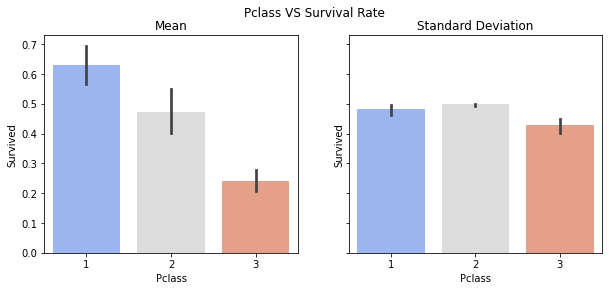

In [325]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(10,4))
pclass_mean = sns.barplot(x='Pclass',y='Survived',ax=axes[0],data = train, palette='coolwarm')
pclass_mean.set_title("Mean")

pclass_var = sns.barplot(x='Pclass',y='Survived',ax=axes[1],data = train, palette='coolwarm',estimator=np.std)
pclass_var.set_title("Standard Deviation")
fig.suptitle("Pclass VS Survival Rate")

Higher class level corresponds to a higher survival rate.

### Gender, Class Level and Survival Rate

Text(0.5, 0.98, 'Gender, Class and Survival Rate')

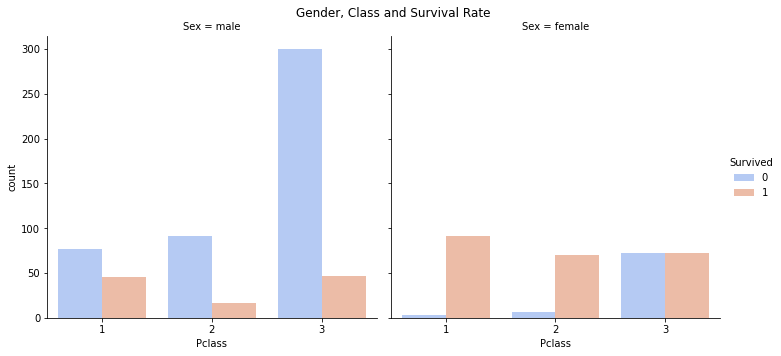

In [326]:
g = sns.catplot(x="Pclass", hue="Survived", col="Sex",
                data=train, kind="count",
                palette='coolwarm')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Gender, Class and Survival Rate")

The previous conclusion that survival rate drops as class level increases is valid for both female and male passengers. Moreover, female passengers have higher survival rate than male in all classes.

### Port of Embarkation and Survival Rate

Text(0.5, 0.98, 'Port of Embarkation VS Survival Rate')

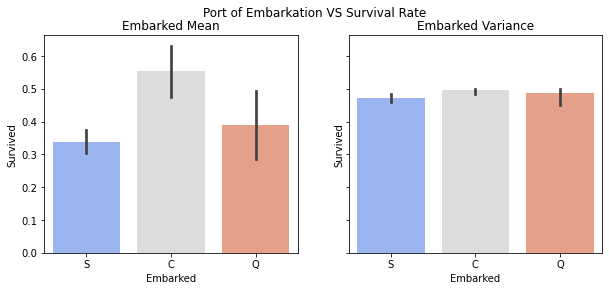

In [327]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(10,4))
embarked_mean = sns.barplot(x='Embarked',y='Survived',ax=axes[0],data = train, palette='coolwarm')
embarked_mean.set_title("Embarked Mean")

embarked_var = sns.barplot(x='Embarked',y='Survived',ax=axes[1],data = train, palette='coolwarm',estimator=np.std)
embarked_var.set_title("Embarked Variance")
fig.suptitle("Port of Embarkation VS Survival Rate")

Passengers embarked on Cherbourg has the highest survival rate, followed by those embarked on Queenstown.

### Gender, Port of Embarkation and Survival Rate

Text(0.5, 0.98, 'Gender, Port of Embarkation and Survival Rate')

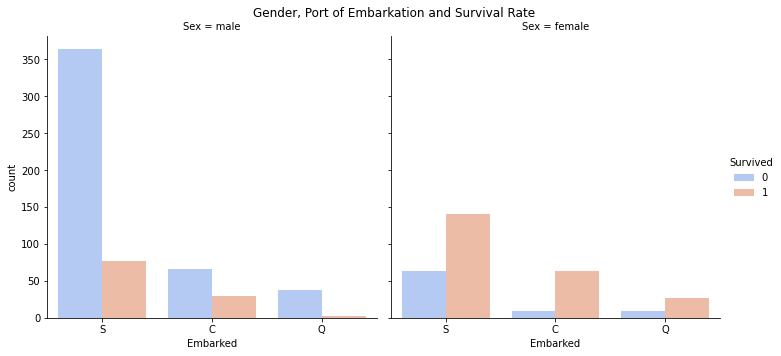

In [328]:
g = sns.catplot(x="Embarked", hue="Survived", col="Sex",
                data=train, kind="count",
                palette='coolwarm')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Gender, Port of Embarkation and Survival Rate")

Male passengers embarked on Cherbourg have higher chance of survival.
Female passengers embarked on Southampton have higher chance of survival.

### Gender, Age and Survival Rate

Text(0.5, 0.98, 'Gender, Age and Survival Rate')

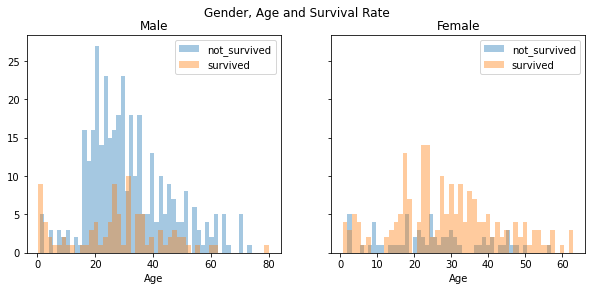

In [329]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(10,4))

male =train[train['Sex']=='male']
ax_m = sns.distplot(male[male['Survived']==0]['Age'],label="not_survived",ax=axes[0],kde=False,bins=50)
ax_m = sns.distplot(male[male['Survived']==1]['Age'],label="survived",ax=axes[0],kde=False,bins=50)
ax_m.set_title("Male")
ax_m.legend()

female = train[train['Sex']=='female']
ax_f = sns.distplot(female[female['Survived']==0]['Age'],label="not_survived",ax=axes[1],kde=False,bins=50)
ax_f = sns.distplot(female[female['Survived']==1]['Age'],label="survived",ax=axes[1],kde=False,bins=50)
ax_f.set_title("Female")
ax_f.legend()
fig.suptitle("Gender, Age and Survival Rate")

Male passengers in age 30-40 have higher survival rate.
Female passengers in age 18-40 have higher survival rate. Also, more female (age 50+) survived than male.
Both female and male children (age under 10) are likely to survive.

### Number of Accompanies and Survival Rate

As the Sibsp and Parch columns both represent a passenger's number of accompanies, I created an additional column as the sum of Sibsp and Parch to see if there is a correlation between number of passengers traveling alone and survival rate. 

In [330]:
# add additional column for total number of accompanies
def create_accompanies_num(train,test):
    combine = [train,test]
    for df in combine:    
        df['accompanies_num'] = df['SibSp']+df['Parch']
        df['Is_Alone'] = np.where(df['accompanies_num']==0, 1, 0)
        df['Is_Alone'].value_counts()
        df.drop(['SibSp','Parch'],axis=1,inplace=True)
    return train,test

In [331]:
train,test = create_accompanies_num(train,test)

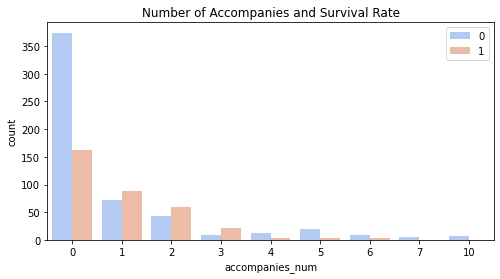

In [332]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x='accompanies_num',hue='Survived',data=train,palette='coolwarm')
ax.set_title("Number of Accompanies and Survival Rate")
ax.legend(loc='upper right')

Passengers traveling with 1 to 3 accompanies have higher survival rate. As a trend exists the total number of accompanies and survival rate, I will keep this column for upcoming model training.

## Data Preprocessing and More Visualizations

We start by counting missing values in all features.

In [333]:
number = train.isnull().sum(axis=0)
percentage = round(number/train.isnull().count(),3)*100
null_count = pd.concat([number,percentage],axis=1,keys=['Total','Percentage'])
null_count

,Total,Percentage
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,177,19.9
Ticket,0,0.0
Fare,0,0.0
Cabin,687,77.1
Embarked,2,0.2
accompanies_num,0,0.0


As 'Embarked' only contains 2 missing values, these rows can be safely removed.

In [334]:
train = train.dropna(axis=0, subset=['Embarked'])
test = test.dropna(axis=0, subset=['Embarked'])

The Cabin column contains more than 75% missing values, I need to determine if discernible trend between cabin level and survival rate to decide if this feature can be safely dropped.

In [335]:
#extract cabin level out of cabin number
def Add_Cabin_Level(train,test):
    combine = [train,test]
    for df in combine:
        df['Cabin_Level'] = df['Cabin'].str[:1].fillna('None')
        df=df.drop(['Cabin'],axis=1,inplace=True)
    return train,test

In [336]:
train,test = Add_Cabin_Level(train,test)

C:\Users\anyi9\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\anyi9\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


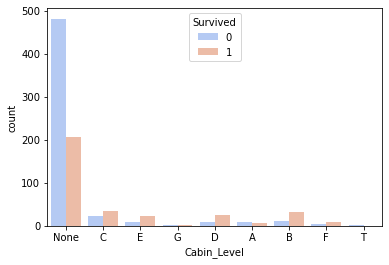

In [337]:
sns.countplot(x='Cabin_Level',hue='Survived',data = train,palette='coolwarm')

Given number of missing values for cabin level is too large and no sufficient information has been provided for filling these values, I will just leave nulls as cabin level None.

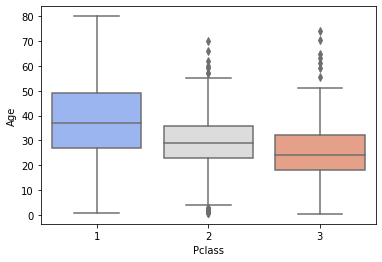

In [338]:
sns.boxplot(x='Pclass',y='Age',data=train,palette='coolwarm')

From plot above, age distribution varies in classes, as passengers in lower classes tended to be younger. Thus, I generated missing ages using normal distribution based on the passenger's class level.

In [339]:
#compute parameters to generate random ages by classes
combine = [train,test]
for (i,df) in enumerate(combine):    
    df_class_agemean=df.groupby('Pclass').mean()['Age']
    df_class_agestd=df.groupby('Pclass').std()['Age']
    df_agena=df.Age.isnull().groupby(df['Pclass']).sum()
    if i==0:
        df_class_train = pd.concat([df_class_agemean,df_class_agestd,df_agena],axis=1)
        df_class_train.columns=['mean','std','na_num']
    else:
        df_class_test = pd.concat([df_class_agemean,df_class_agestd,df_agena],axis=1)
        df_class_test.columns=['mean','std','na_num']

In [340]:
def generate_age(row,df_class):
    new_age = row['Age']
    if pd.isnull(row['Age']):
        new_age=abs(np.random.normal(df_class.loc[row['Pclass'],'mean'],df_class.loc[row['Pclass'],'std'],1))
        return new_age
    return new_age
train['Age']=train.apply(lambda x:generate_age(x ,df_class_train),axis=1)
test['Age']=test.apply(lambda x:generate_age(x ,df_class_test),axis=1)

C:\Users\anyi9\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Now I turned categorical variables 'Pclass', 'Embarked', 'Cabin_Level' and 'Sex' into dummy variables using one-hot encoding.

In [341]:
def create_dummies(df):
    df_Pclass_d = pd.get_dummies(df['Pclass'],prefix='Pclass')
    df_Embarked_d = pd.get_dummies(df['Embarked'],prefix='Embarked')
    df_Cabin_d = pd.get_dummies(df['Cabin_Level'],prefix='Carbin')
    df_Sex_d = pd.get_dummies(df['Sex'],prefix='sex')
    df = df.drop(['Ticket','Pclass','Embarked','Cabin_Level','Sex'],axis=1)
    df = pd.concat([df,df_Sex_d,df_Pclass_d,df_Embarked_d,df_Cabin_d],axis=1)
    return df

In [342]:
train = create_dummies(train)
test = create_dummies(test)

In [343]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         889 non-null    int64  
 1   Name             889 non-null    object 
 2   Age              889 non-null    object 
 3   Fare             889 non-null    float64
 4   accompanies_num  889 non-null    int64  
 5   Is_Alone         889 non-null    int32  
 6   sex_female       889 non-null    uint8  
 7   sex_male         889 non-null    uint8  
 8   Pclass_1         889 non-null    uint8  
 9   Pclass_2         889 non-null    uint8  
 10  Pclass_3         889 non-null    uint8  
 11  Embarked_C       889 non-null    uint8  
 12  Embarked_Q       889 non-null    uint8  
 13  Embarked_S       889 non-null    uint8  
 14  Carbin_A         889 non-null    uint8  
 15  Carbin_B         889 non-null    uint8  
 16  Carbin_C         889 non-null    uint8  
 17  Carbin_D        

### Divide age into equal sized chunks

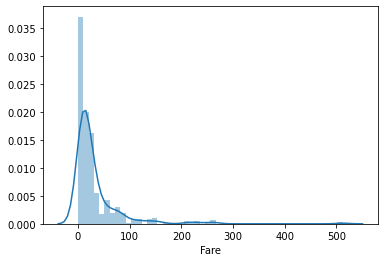

In [344]:
sns.distplot(train['Fare'])

From the plot above, 'Age' gives a left-skewed long tail distribution. I divided fare into 10 equal-sized bins, turning continuous numerical values into discrete bands. 

In [345]:
bins = [x*(1/9) for x in range(1,9)]
ranges = df['Age'].quantile(bins)

In [346]:
train['Age_group'] = pd.cut(train['Age'], bins=[0,14,19,23,26,30,33,39,48,100],labels=[x for x in range(1,10)],include_lowest=True).astype(int)
test['Age_group'] = pd.cut(test['Age'], bins=[0,14,19,23,26,30,33,39,48,100],labels=[x for x in range(1,10)],include_lowest=True).astype(int)

In [347]:
train['Age_group'].isnull().sum()

0

### Divide fare into equal sized chunks

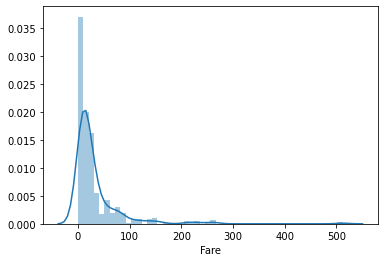

In [348]:
sns.distplot(train['Fare'])

Similarly, I created a fare band converting continuous values into discrete categorical values. Missing values are filled by the median.

In [349]:
bins = [x*(1/9) for x in range(1,10)]
ranges = df['Fare'].quantile(bins)

In [350]:
train['Fare'] = train['Fare'].fillna(train.median()['Fare'])
test['Fare'] = test['Fare'].fillna(test.median()['Fare'])

In [351]:
train['Fare_group'] = pd.cut(train['Fare'], bins=[0,7.73,7.85,8.66,13,16,26,34.5,73.5,513],labels=[x for x in range(1,10)],include_lowest=True).astype(int)
test['Fare_group'] = pd.cut(test['Fare'], bins=[0,7.73,7.85,8.66,13,16,26,34.5,73.5,513],labels=[x for x in range(1,10)],include_lowest=True).astype(int)

Now we can drop original 'Fare' and 'Age'. 

In [352]:
train.drop(['Fare','Age'],axis=1,inplace=True)
test.drop(['Fare','Age'],axis=1,inplace=True)

In [353]:
test.isnull().sum()

Name               0
accompanies_num    0
Is_Alone           0
sex_female         0
sex_male           0
Pclass_1           0
Pclass_2           0
Pclass_3           0
Embarked_C         0
Embarked_Q         0
Embarked_S         0
Carbin_A           0
Carbin_B           0
Carbin_C           0
Carbin_D           0
Carbin_E           0
Carbin_F           0
Carbin_G           0
Carbin_None        0
Age_group          0
Fare_group         0
dtype: int64

### Title out of names

It is hard to extract information out of names themselves. However, it may be worthwhile exploring the title in front of names, as it represents gender, status and occupation on ship.

In [354]:
def create_title(df):
    df['Title']=df.Name.str.extract('([A-Za-z]+)\.',expand=False)
    #replace infrequent title by 'None'
    df['Title']=df['Title'].replace(['Col','Major','Jonkheer','Mme','Countess','Sir','Don','Capt','Lady','Rev'],'None')
    #regroup 'Mlle', 'Ms' into 'Miss'
    df['Title']=df['Title'].replace(['Mlle','Ms'],'Miss')
    #create dummy variables
    title_d = pd.get_dummies(df['Title'],prefix='title')
    df=pd.concat([df,title_d],axis=1)
    df.drop(['Title','Name'],axis=1,inplace=True)
    return df

In [355]:
train = create_title(train)
test = create_title(test)

In [356]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   accompanies_num  418 non-null    int64
 1   Is_Alone         418 non-null    int32
 2   sex_female       418 non-null    uint8
 3   sex_male         418 non-null    uint8
 4   Pclass_1         418 non-null    uint8
 5   Pclass_2         418 non-null    uint8
 6   Pclass_3         418 non-null    uint8
 7   Embarked_C       418 non-null    uint8
 8   Embarked_Q       418 non-null    uint8
 9   Embarked_S       418 non-null    uint8
 10  Carbin_A         418 non-null    uint8
 11  Carbin_B         418 non-null    uint8
 12  Carbin_C         418 non-null    uint8
 13  Carbin_D         418 non-null    uint8
 14  Carbin_E         418 non-null    uint8
 15  Carbin_F         418 non-null    uint8
 16  Carbin_G         418 non-null    uint8
 17  Carbin_None      418 non-null    uint8
 18  Age_gro

### Create additional feature as product of age and fare group number

In [357]:
train['Fare_Age']=train['Fare_group']*train['Age_group']
test['Fare_Age']=test['Fare_group']*test['Age_group']

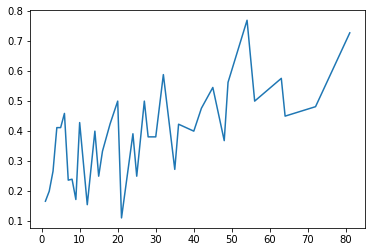

In [358]:
fare_age = train.groupby('Fare_Age').mean()['Survived']
plt.plot(fare_age)

It seems there is an increasing trend of survival rate as the product of these two increases, thus I maintained this feature.

## Model Training

In [359]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [360]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]

### logistic regression

In [361]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, Y_train)
logreg.score(X_train,Y_train)*100

83.80202474690664

### SVM
SVM with grid search

In [362]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
grid.fit(X_train,Y_train)
grid.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.618, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.618, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.618, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.618, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.616, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.640, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.640, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.635, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.640, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.627, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.584, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.787, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.758, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.797, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.635, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.725, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.713, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.753, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    5.6s finished


{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

In [363]:
acc_svc = grid.score(X_train,Y_train)*100
acc_svc

83.01462317210348

### KNN

In [364]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(test)

Text(0, 0.5, 'Error Rate')

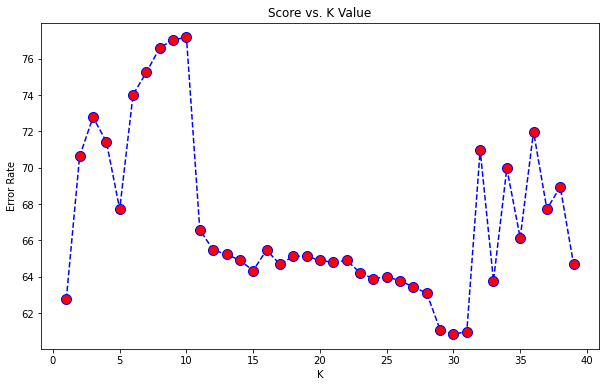

In [365]:
#find the optimal k value
scores=[0]*39
for i in range(1,40):
    knn = KNN(n_neighbors=i)
    knn.fit(scaled_train,Y_train)
    scores[i-1]=round(knn.score(X_train, Y_train)*100,2)
plt.figure(figsize=(10,6))
plt.plot(range(1,40),scores,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Score vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [366]:
knn_final = KNN(n_neighbors=9)
knn_final.fit(scaled_train,Y_train)
score_knn=round(knn_final.score(X_train, Y_train)*100,2)
score_knn

77.05

### Gaussian

In [367]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
score_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
score_gaussian

77.05

### Perceptron

In [368]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
score_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
score_perceptron

61.87

### Stochastic Gradient Descent

In [369]:
sgd = SGDClassifier()
sgd.fit(scaled_train, Y_train)
score_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
score_sgd

61.75

### Decision Tree

In [370]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,Y_train)
score_dtree = round(dtree.score(X_train, Y_train) * 100, 2)
score_dtree

94.49

### Random Forest

In [371]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
score_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
score_random_forest

94.49

Both decision tree and random forest gives the highest score. I chose random forest to make predictions on test set.

### Prediction and submission

In [372]:
test['Survived'] = random_forest.predict(test)
test.head()

,accompanies_num,Is_Alone,sex_female,sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,...,Fare_group,title_Dona,title_Dr,title_Master,title_Miss,title_Mr,title_Mrs,title_None,Fare_Age,Survived
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,0,1,0,1,0,0,1,0,1,0,...,2,0,0,0,0,1,0,0,14,0
893,1,0,1,0,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,8,1
894,0,1,0,1,0,1,0,0,1,0,...,4,0,0,0,0,1,0,0,36,0
895,0,1,0,1,0,0,1,0,0,1,...,4,0,0,0,0,1,0,0,20,0
896,2,0,1,0,0,0,1,0,0,1,...,4,0,0,0,0,0,1,0,12,1


In [373]:
test['PassengerId']=test.index
submission = pd.DataFrame({"PassengerId":test['PassengerId'],
                          "Survived":test['Survived']})
submission.to_csv("submission.csv",index=False)